<a href="https://colab.research.google.com/github/Venuram/Machine-Learning-ML/blob/master/Corona_Virus_time_series_forecasting_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <b> Time Series Forecasting with LSTMs for Daily Coronavirus Cases

Time series data captures a series of data points recorded at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of sales a company makes.

Many classical methods (e.g. ARIMA) try to deal with Time Series data with varying success (not to say they are bad at it). In the last couple of years, Long Short Term Memory Networks (LSTM) models have become a very useful method when dealing with those types of data.

Recurrent Neural Networks (LSTMs are one type of those) are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

In [0]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

import pandas.util.testing as tm

<b>Novel Coronavirus (COVID-19)</b>

The novel Coronavirus (Covid-19) has spread around the world very rapidly. At the time of this writing, Worldometers.info shows that there are more than 95,488 confirmed cases in more than 84 countries.

The top 4 worst-affected (by far) are China (the source of the virus), South Korea, Italy, and Iran. Unfortunately, many cases are currently not reported due to:

A person can get infected without even knowing (asymptomatic)
Incorrect data reporting
Not enough test kits
The symptoms look a lot like the common flu
How dangerous is this virus?
Except for the common statistics you might see cited on the news, there are some good and some bad news:

More than 80% of the confirmed cases recover without any need of medical attention
3.4% Mortality Rate estimate by the World Health Organization (WHO) as of March 3
The reproductive number which represents the average number of people to which a single infected person will transmit the virus is between 1.4 and 2.5 (WHO's estimated on Jan. 23)
The last one is really scary. It sounds like we can witness some crazy exponential growth if appropriate measures are not put in place.

Let's get started!

In [0]:
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
mydata = pd.read_csv(url)

<h2> <b>Daily Cases Dataset </b> </h2>

The data is provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) and contains the number of reported daily cases by country.

In [73]:
mydata.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16


In [0]:
df = mydata.copy()

<b>Two things to note here:</b>

The data contains a province, country, latitude, and longitude. We won't be needing those.
The number of cases is cumulative. We'll undo the accumulation.

In [0]:
df = df.drop(columns=['Province/State','Country/Region','Lat','Long'])

In [76]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16


<b> Checking the missing values

In [77]:
df.isnull().sum()

1/22/20    0
1/23/20    0
1/24/20    0
1/25/20    0
1/26/20    0
          ..
4/2/20     0
4/3/20     0
4/4/20     0
4/5/20     0
4/6/20     0
Length: 76, dtype: int64

In [0]:
daily_cases = df.sum(axis=0)

In [79]:
daily_cases

1/22/20        555
1/23/20        654
1/24/20        941
1/25/20       1434
1/26/20       2118
            ...   
4/2/20     1013157
4/3/20     1095917
4/4/20     1197405
4/5/20     1272115
4/6/20     1345048
Length: 76, dtype: int64

In [0]:
daily_cases.index = pd.to_datetime(daily_cases.index)

In [81]:
daily_cases

2020-01-22        555
2020-01-23        654
2020-01-24        941
2020-01-25       1434
2020-01-26       2118
               ...   
2020-04-02    1013157
2020-04-03    1095917
2020-04-04    1197405
2020-04-05    1272115
2020-04-06    1345048
Length: 76, dtype: int64

Let's sum all rows, so we get the cumulative daily cases:

Text(0.5, 1.0, 'Cumulative cases')

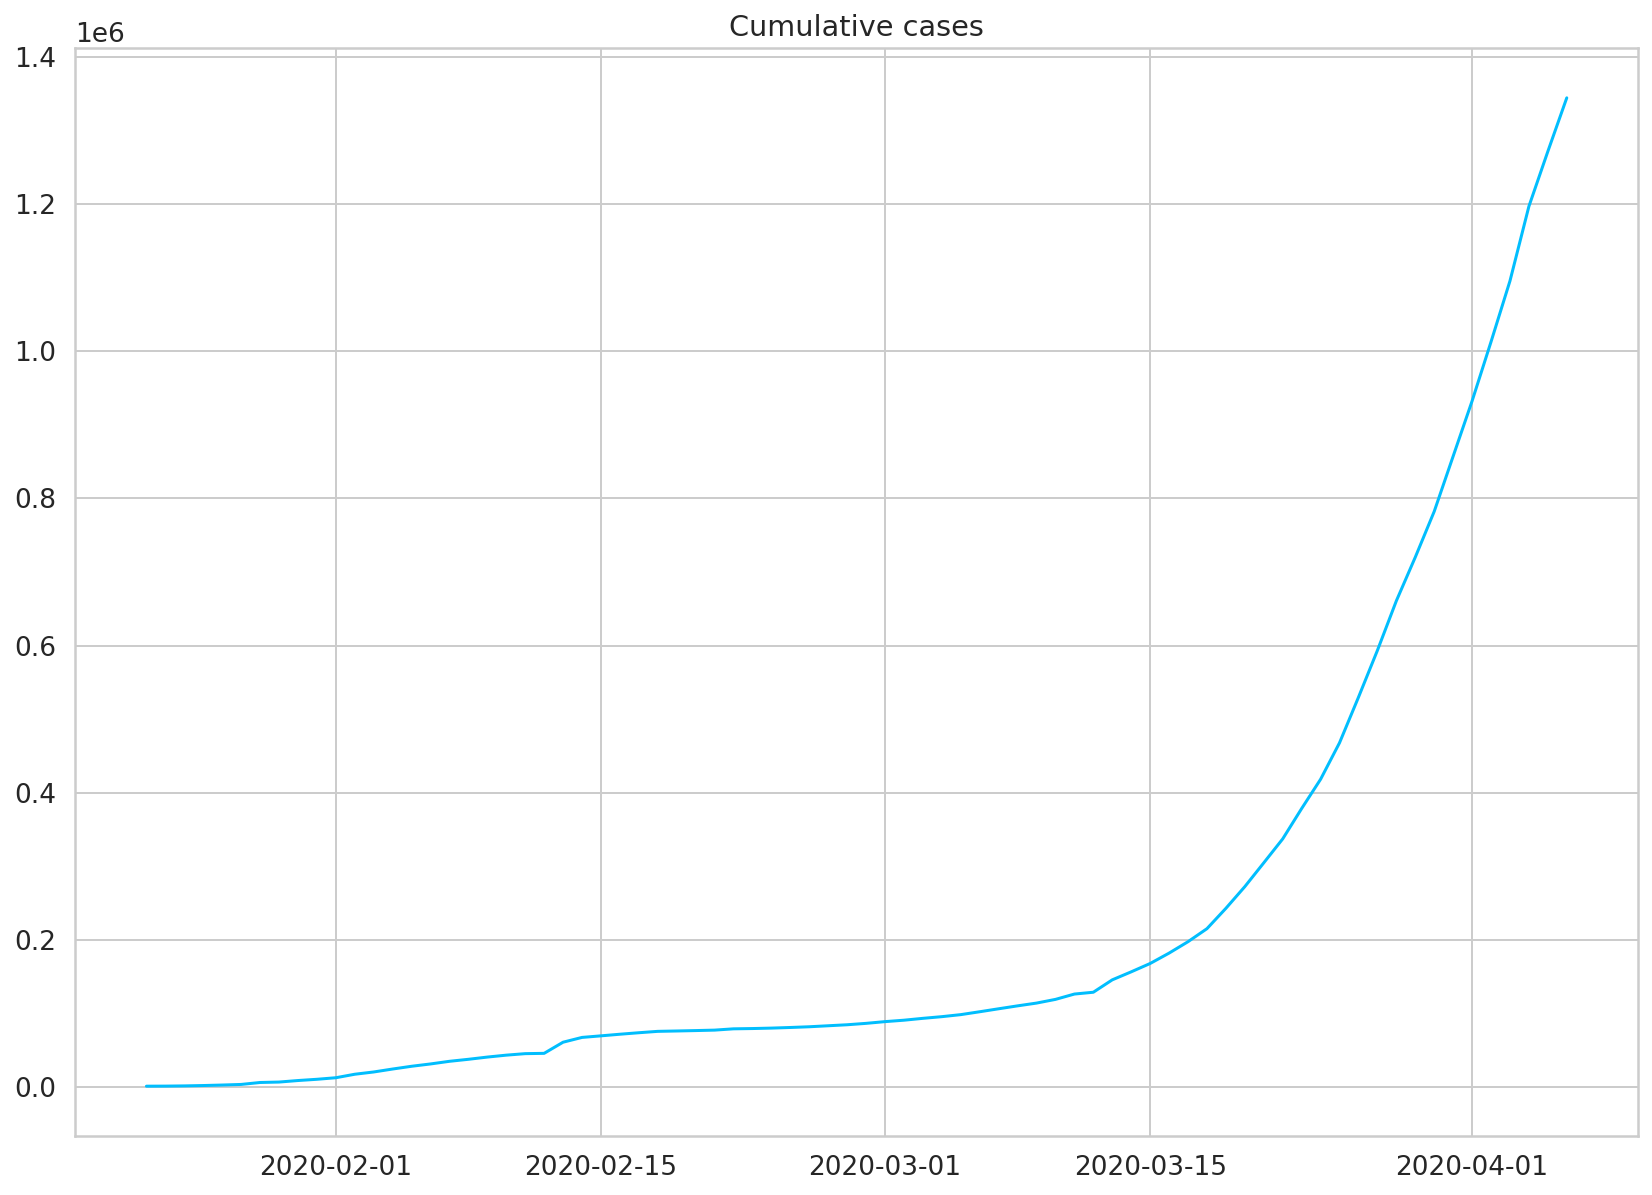

In [82]:
plt.plot(daily_cases)
plt.title('Cumulative cases')

We'll undo the accumulation by subtracting the current value from the previous. We'll preserve the first value of the sequence:

In [0]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)

In [84]:
daily_cases

2020-01-22       555
2020-01-23        99
2020-01-24       287
2020-01-25       493
2020-01-26       684
               ...  
2020-04-02     80552
2020-04-03     82760
2020-04-04    101488
2020-04-05     74710
2020-04-06     72933
Length: 76, dtype: int64

Text(0.5, 1.0, 'Daily cases')

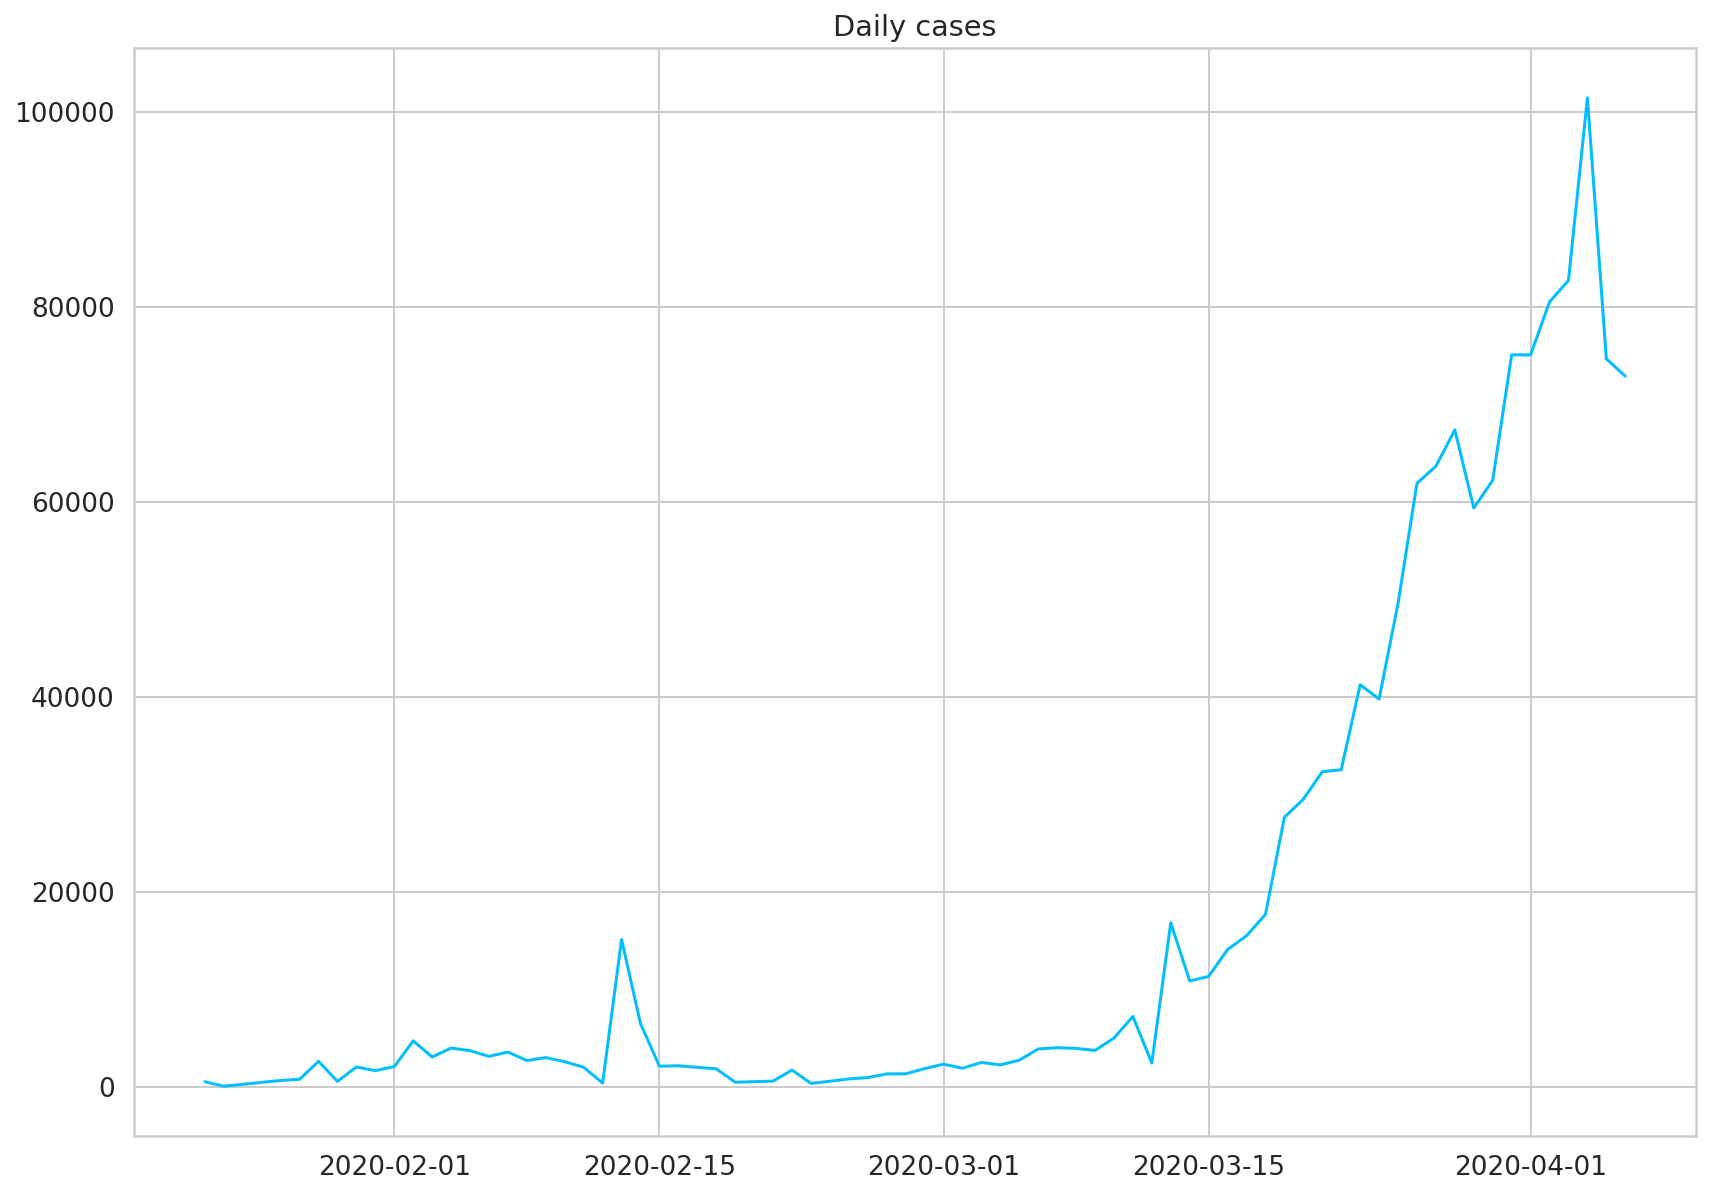

In [85]:
plt.plot(daily_cases)
plt.title('Daily cases')

There is a gradual increase in the graph which depicts that we have number of cases increasing on a daily basis and we will further proceed to check how the LSTM model works well in prediction.

Let's check the amount of data we have:

In [86]:
daily_cases.shape

(76,)

In [0]:
test_data_size = 20
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

In [88]:
train_data.shape

(56,)

In [89]:
test_data.shape

(20,)

We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the MinMaxScaler from scikit-learn:

In [0]:
scale = MinMaxScaler()

scale = scale.fit(np.expand_dims(train_data, axis=1))
train_data_scaled = scale.transform(np.expand_dims(train_data, axis=1))
test_data_scaled = scale.transform(np.expand_dims(test_data,axis=1))

Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:

In [0]:
def create_sequences(data, sequence_length):
  xs = []
  ys = []

  for i in range(len(data) - sequence_length - 1):
    x = data[i:i+sequence_length]
    y = data[i+sequence_length]
    xs.append(x)
    ys.append(y)
    
  return np.array(xs), np.array(ys)

Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [0]:
sequence_length = 5

x_train, y_train = create_sequences(train_data_scaled, sequence_length)
x_test, y_test = create_sequences(test_data_scaled, sequence_length)

In [0]:
X_train = torch.from_numpy(x_train).float()
Y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(x_test).float()
Y_test = torch.from_numpy(y_test).float()

In [94]:
X_train.shape

torch.Size([50, 5, 1])

In [95]:
X_train[:2]

tensor([[[0.0272],
         [0.0000],
         [0.0112],
         [0.0235],
         [0.0349]],

        [[0.0000],
         [0.0112],
         [0.0235],
         [0.0349],
         [0.0424]]])

In [96]:
Y_train.shape

torch.Size([50, 1])

In [97]:
Y_train[:2]

tensor([[0.0424],
        [0.1523]])

In [0]:
#X_train = torch.Tensor(X_train)
#Y_train = torch.Tensor(Y_train)

<h2> <b> Building the LSTM Model

In [0]:
class CoronaPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers = 2):
    super(CoronaPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        dropout = 0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
     self.hidden = (
         torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
         torch.zeros(self.n_layers, self.seq_len, self.n_hidden)          
     )

  def forward(self, sequences):
     lstm_out, self.hidden = self.lstm(
         sequences.view(len(sequences), self.seq_len, -1),
         self.hidden
     )
     last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
     y_pred = self.linear(last_time_step)
     return y_pred

Our CoronaVirusPredictor contains 3 methods:

<b> constructor </b>- initialize all helper data and create the layers

<b> reset_hidden_state </b>- we'll use a stateless LSTM, so we need to reset the state after each example

<b>forward </b>- get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

<b> Training the Model

In [0]:
def train_model(
    model,
    train_data,
    train_labels,
    test_data=None,
    test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-5)
  num_epochs = 820

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), Y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), Y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both.

In [113]:
model = CoronaPredictor(
    n_features = 1,
    n_hidden = 512,
    seq_len = sequence_length,
    n_layers = 2
)

model, train_hist, test_hist, = train_model(
    model,
    X_train,
    Y_train,
    X_test,
    Y_test
)

Epoch 0 train loss: 5.06657600402832 test loss: 236.93736267089844
Epoch 10 train loss: 4.781021595001221 test loss: 234.77166748046875
Epoch 20 train loss: 4.485579013824463 test loss: 233.2758331298828
Epoch 30 train loss: 4.244687557220459 test loss: 231.3101043701172
Epoch 40 train loss: 3.9669196605682373 test loss: 228.6534423828125
Epoch 50 train loss: 3.712820529937744 test loss: 227.26266479492188
Epoch 60 train loss: 3.4827523231506348 test loss: 224.70582580566406
Epoch 70 train loss: 3.277204751968384 test loss: 221.55055236816406
Epoch 80 train loss: 3.044506072998047 test loss: 219.88766479492188
Epoch 90 train loss: 2.8698387145996094 test loss: 216.76412963867188
Epoch 100 train loss: 2.7163949012756348 test loss: 213.16075134277344
Epoch 110 train loss: 2.591830015182495 test loss: 209.71942138671875
Epoch 120 train loss: 2.496304512023926 test loss: 207.197021484375
Epoch 130 train loss: 2.4558639526367188 test loss: 204.57940673828125
Epoch 140 train loss: 2.46138429

Let's have a look at the train and test loss:

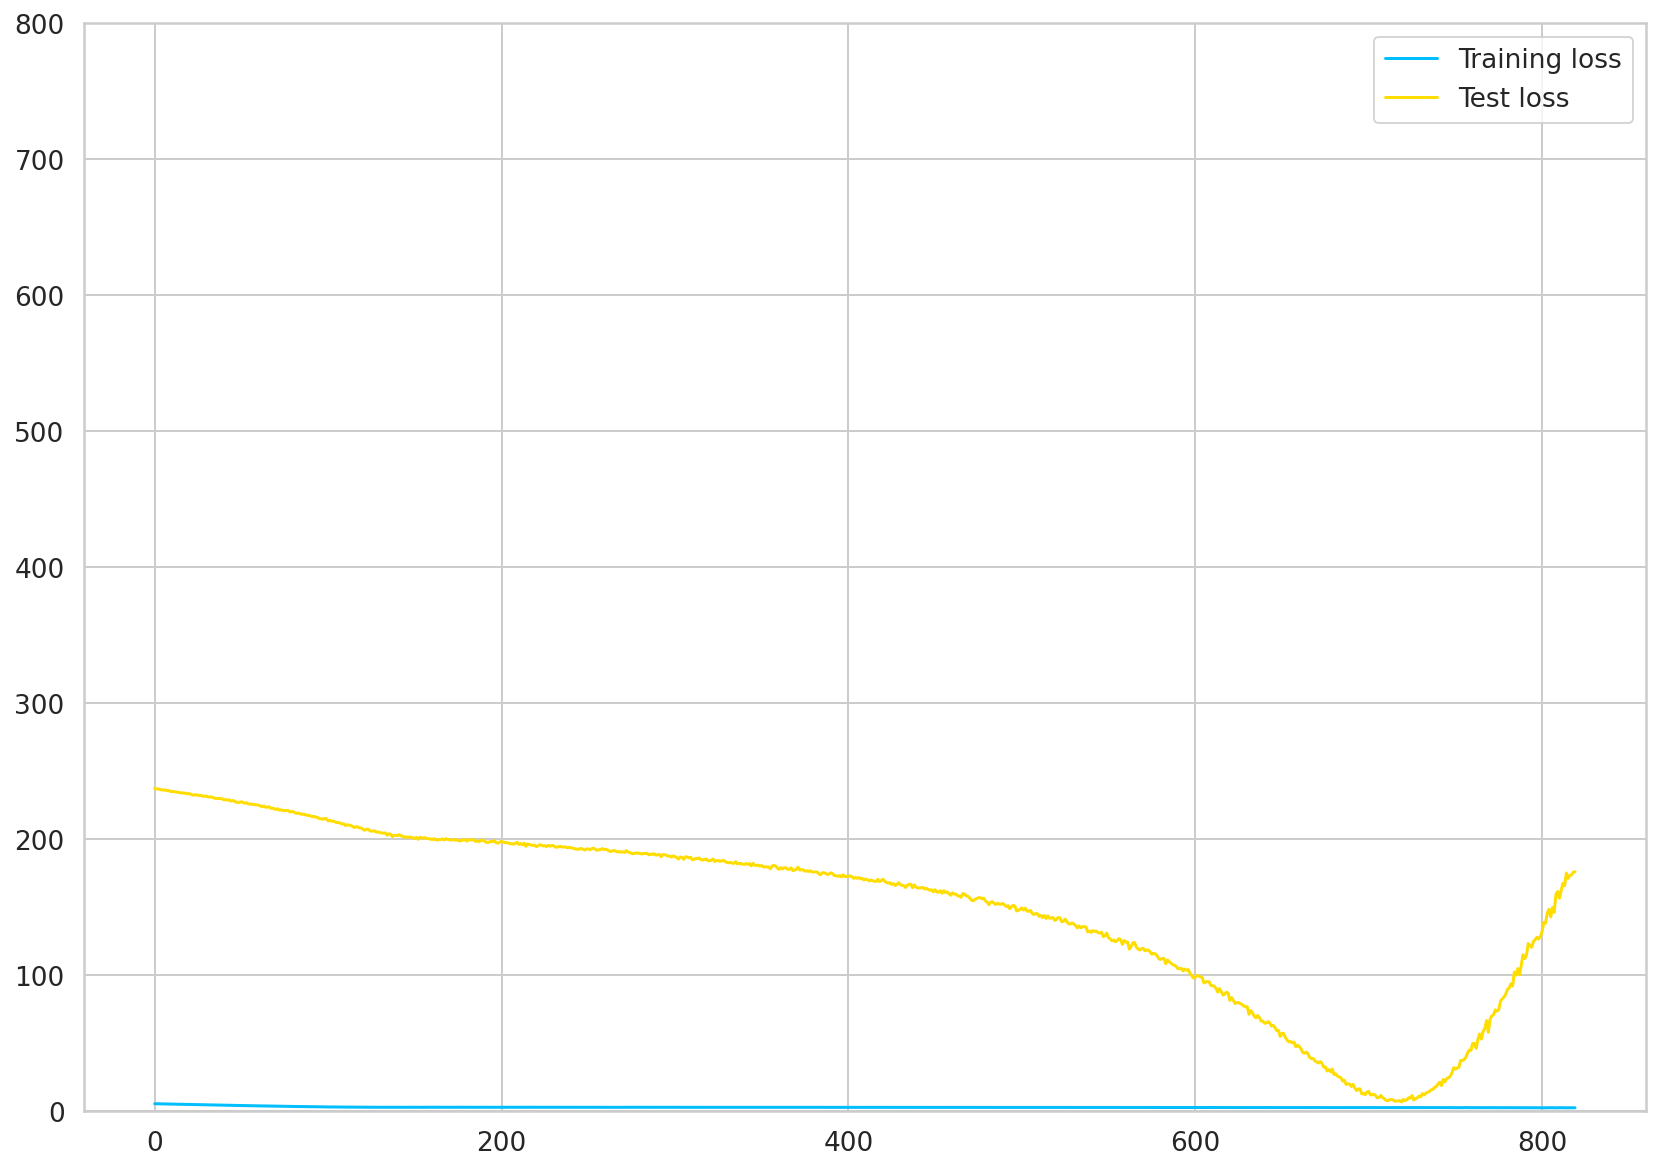

In [114]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 800))
plt.legend();

Our model's test loss seems to reduce slowly and that too racing through so many epochs it managed to reach as close to the train loss around 710th Epoch. 

Closer view of the parabolic downcurve( Test Loss) where it struggles over highs and lows while slowly decresing the loss factor.

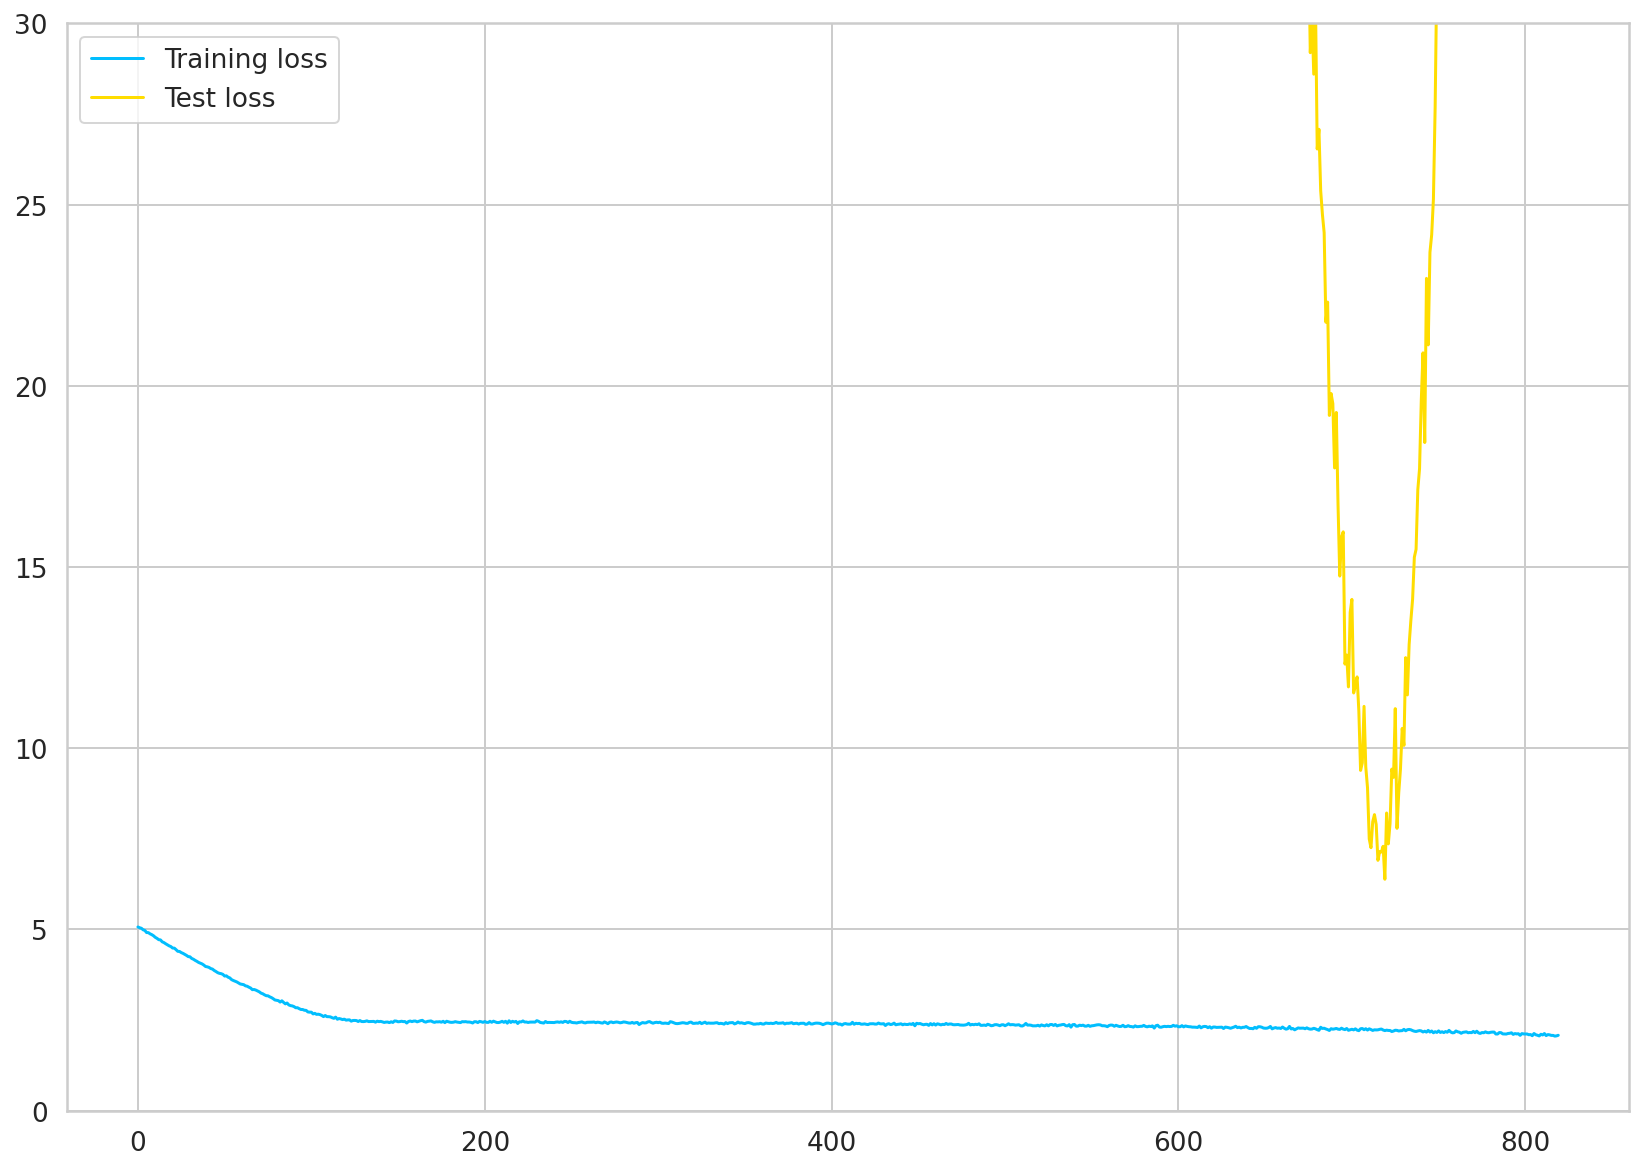

In [115]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 30))
plt.legend();

<b> Predicting daily cases </b>

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [0]:
scaler = MinMaxScaler()

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, sequence_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [0]:
true_cases = scale.inverse_transform(
    np.expand_dims(Y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scale.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

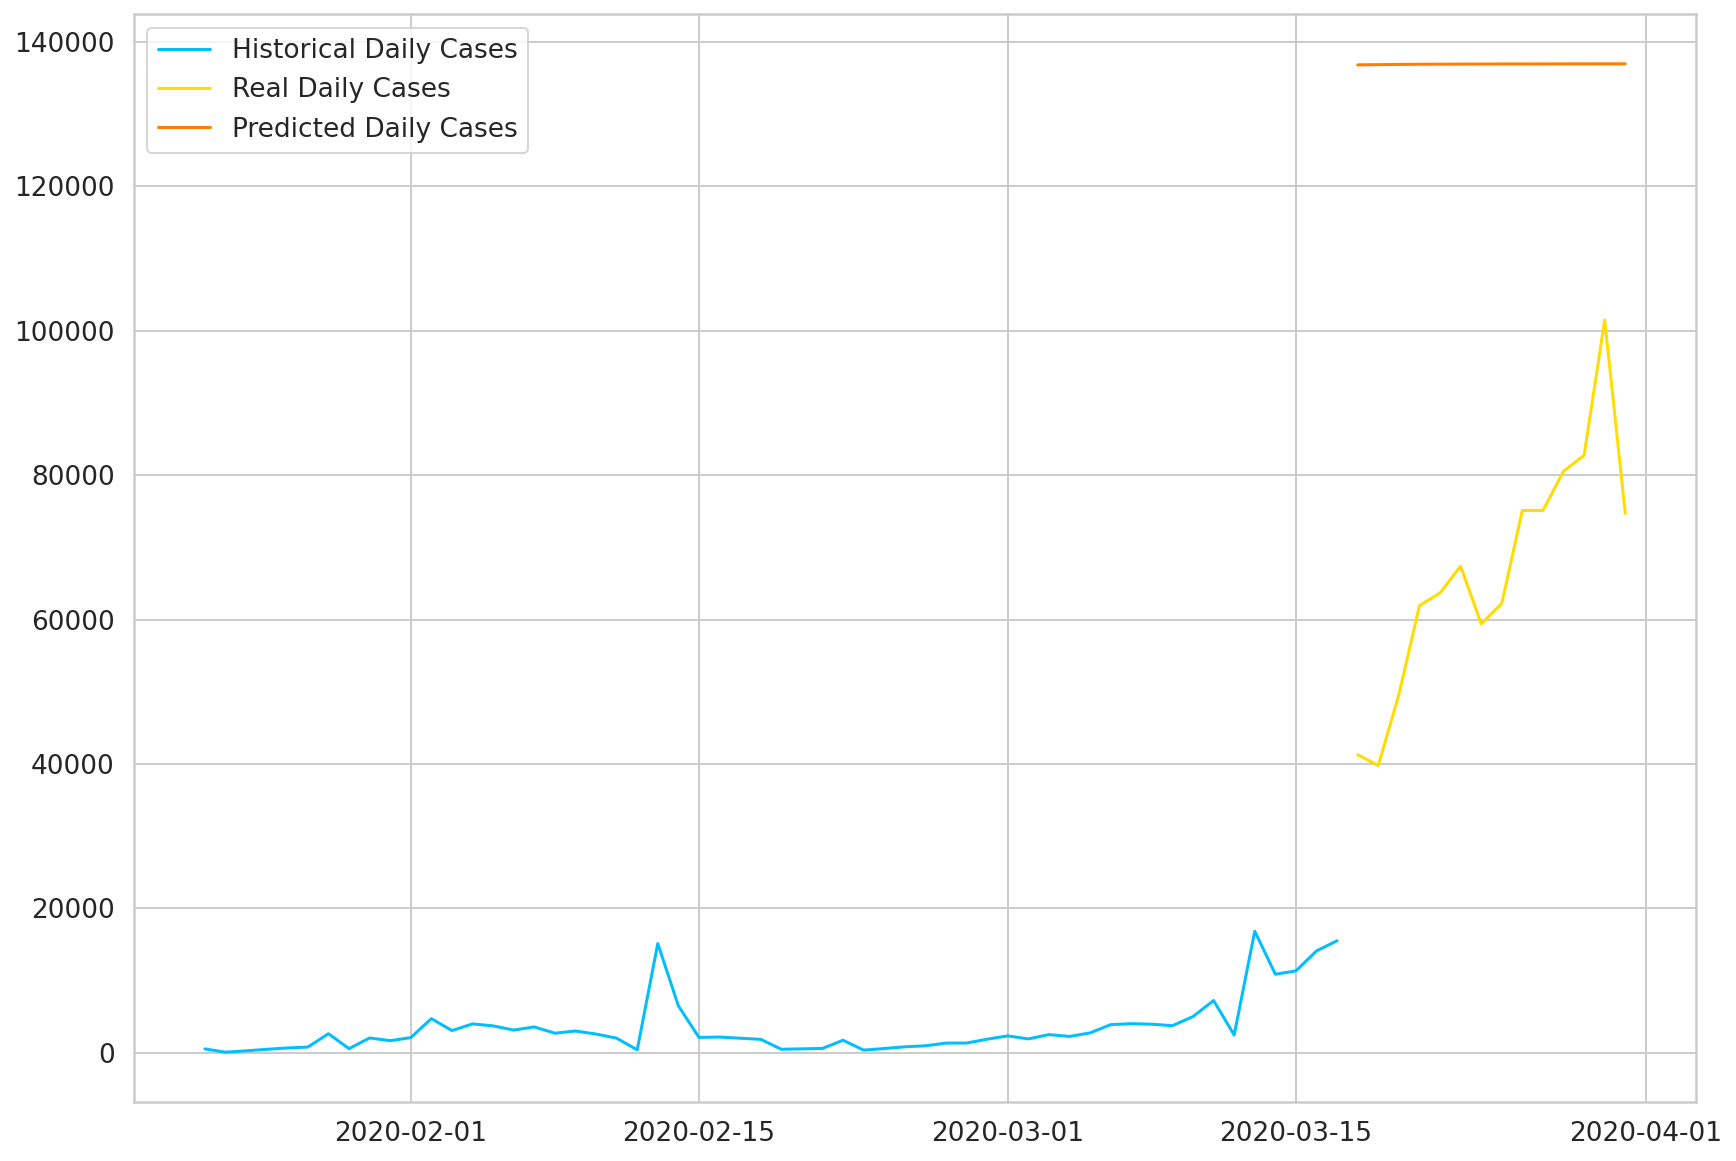

In [129]:
plt.plot(
  daily_cases.index[:len(train_data_scaled)], 
  scale.inverse_transform(train_data_scaled).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data_scaled):len(train_data_scaled) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data_scaled):len(train_data_scaled) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [130]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(76, 1)

In [134]:
X_all, y_all = create_sequences(all_data, sequence_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=sequence_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 4.663326263427734
Epoch 10 train loss: 4.403751850128174
Epoch 20 train loss: 4.146347999572754
Epoch 30 train loss: 3.915410280227661
Epoch 40 train loss: 3.6869819164276123
Epoch 50 train loss: 3.4665441513061523
Epoch 60 train loss: 3.2884364128112793
Epoch 70 train loss: 3.098418712615967
Epoch 80 train loss: 2.9420084953308105
Epoch 90 train loss: 2.7856884002685547
Epoch 100 train loss: 2.6777265071868896
Epoch 110 train loss: 2.5808587074279785
Epoch 120 train loss: 2.507566213607788
Epoch 130 train loss: 2.4821646213531494
Epoch 140 train loss: 2.4762794971466064
Epoch 150 train loss: 2.45257568359375
Epoch 160 train loss: 2.462027072906494
Epoch 170 train loss: 2.452500104904175
Epoch 180 train loss: 2.444762706756592
Epoch 190 train loss: 2.4537603855133057
Epoch 200 train loss: 2.4350852966308594
Epoch 210 train loss: 2.4564120769500732
Epoch 220 train loss: 2.4398064613342285
Epoch 230 train loss: 2.4246768951416016
Epoch 240 train loss: 2.43487048149108

In [0]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, sequence_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

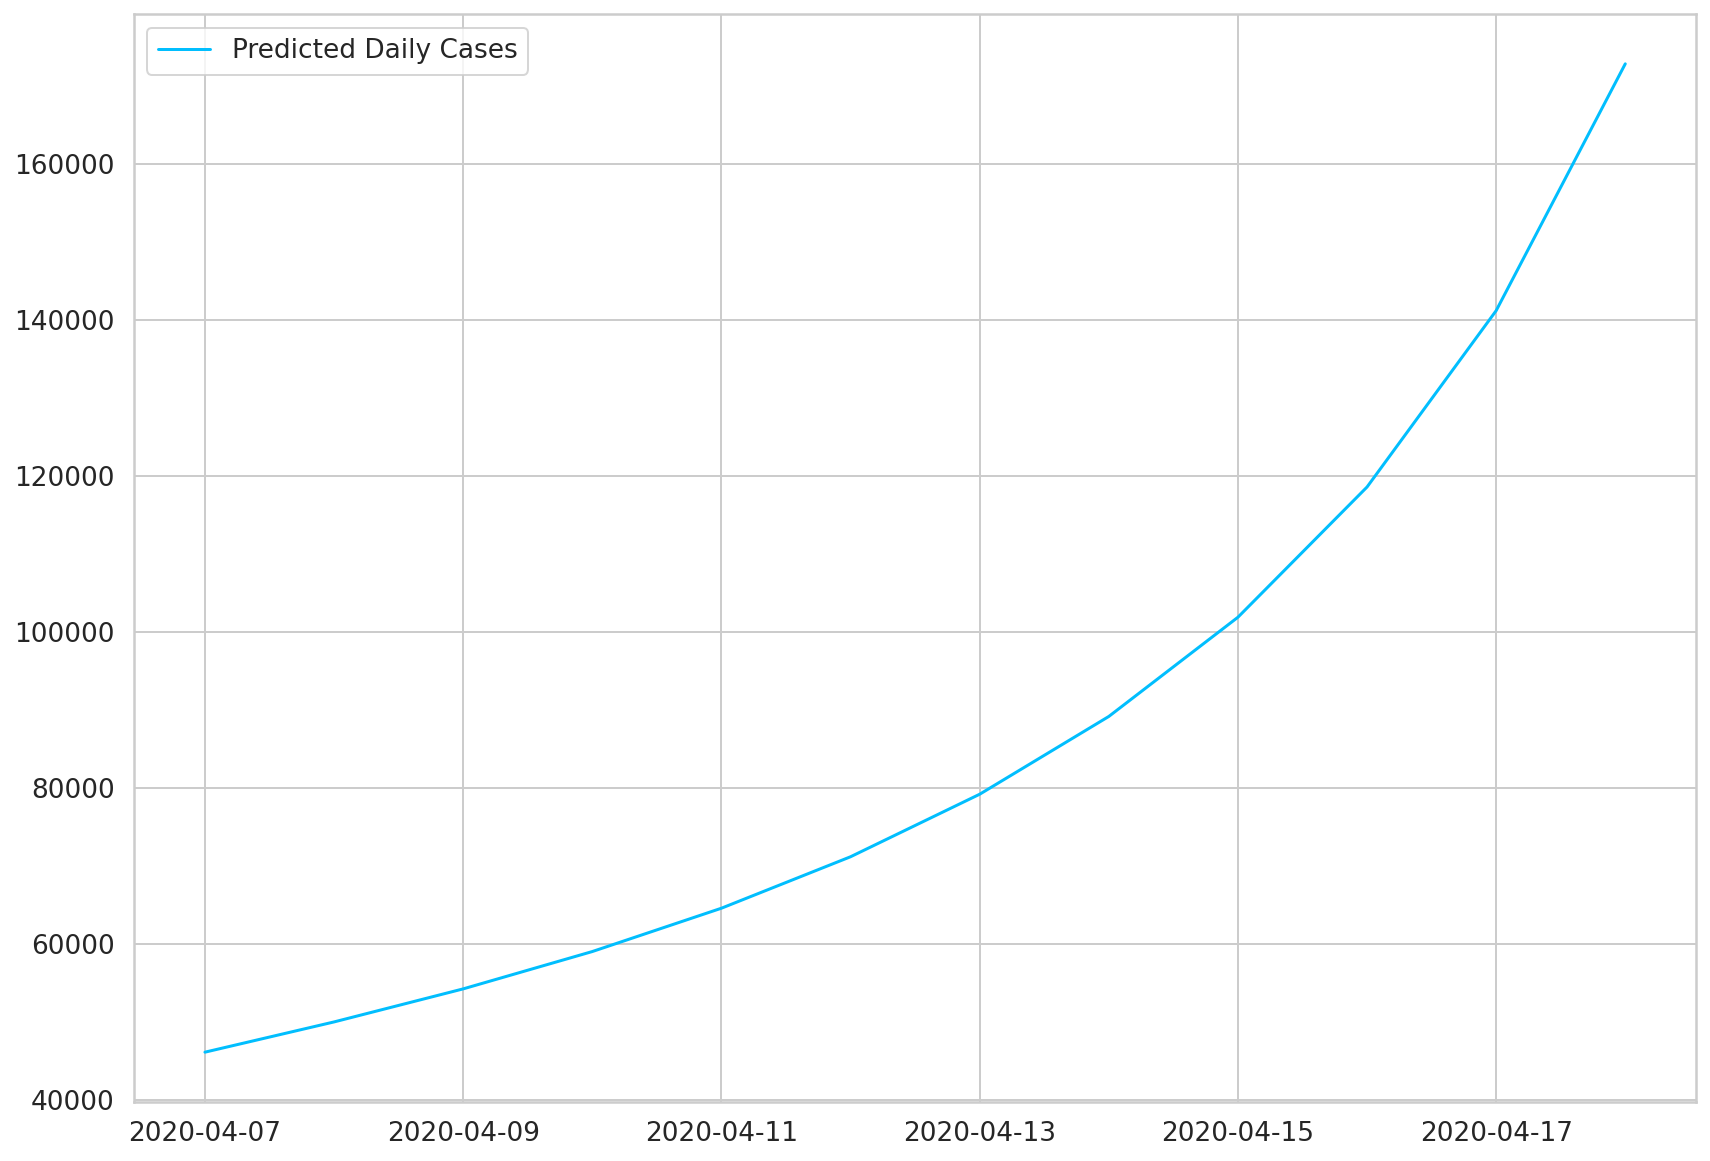

In [137]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

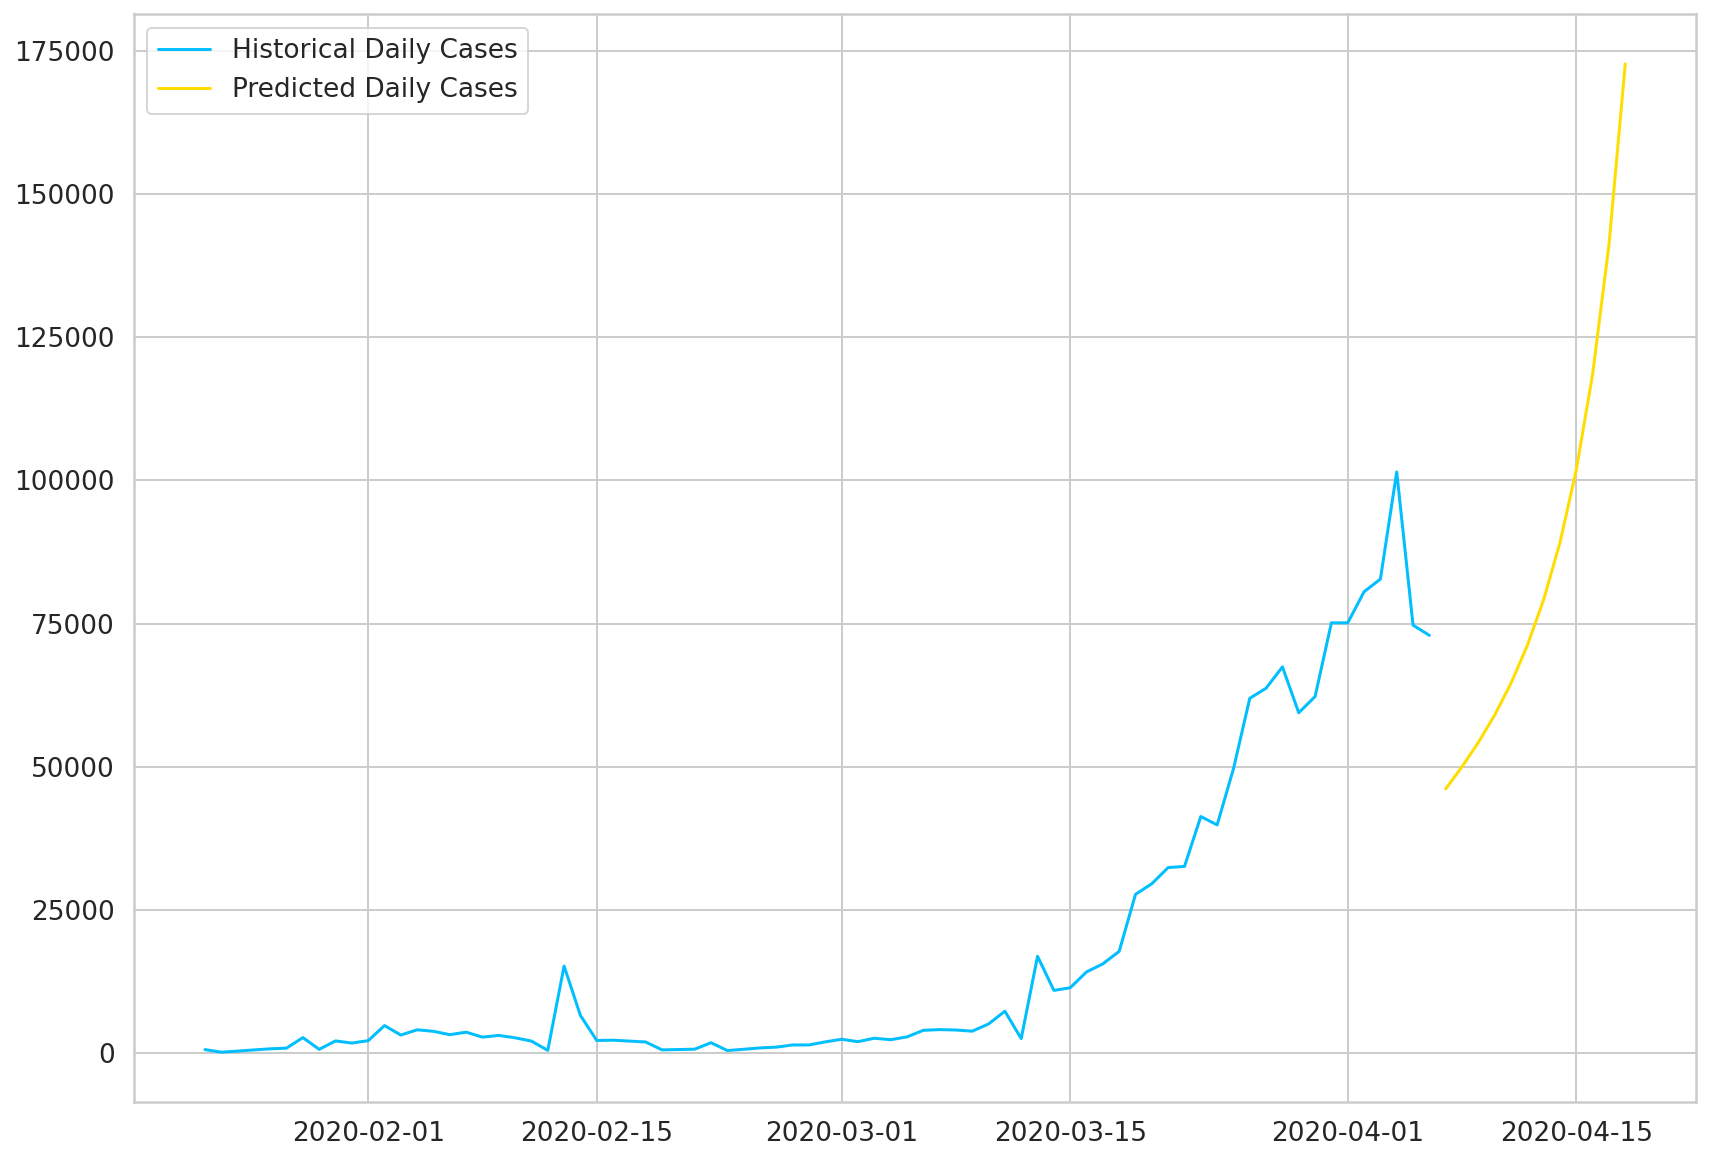

In [138]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

The model performs to the level when fed with maximum data compared to the limited availability of resource previously. 

It predicts the future results representing the gradual increase of number of cases for CoVid19 which is a depressing fact in reality. 

<b> There could be around 1,75,000 registered cases for Corona Virus when it is April 15th, 2020 and this might further increase/decrease according to the future data that's been presented. </b>



The problem of predicting daily Covid-19 cases is a hard one. We're amidst an outbreak, and there's more to be done.